# Homework 3

In [1]:
import string
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
import time
from utilities import *

In [2]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [3]:
sequence = 2 # Number of lines in a sequence
space = False # Whether to include spaces as words in the sequences
split_hyphen = False # Whether to split hyphenated words

In [4]:
path = './poem_data/shakespeare.txt'
raw_data, data, avg_sentence_len_char, max_sentence_len_word = poem_info(path, space, split_hyphen)
print(max_sentence_len_word)

for i in range(len(data)):
    data[i] = data[i] + '~'
data = np.array([word for line in data for word in line])
data = np.char.lower(data)

15


## Problem A

In [5]:
word_data = word_tokenized_input(raw_data, sequence, split_hyphen, max_sentence_len_word, space)
print(word_data)

[['from' 'fairest' 'creatures' ... '0' '0' '~']
 ['that' 'thereby' "beauty's" ... '0' '0' '~']
 ['but' 'as' 'the' ... '0' '0' '&']
 ...
 ['which' 'from' "love's" ... '0' '0' '~']
 ['growing' 'a' 'bath' ... 'thrall,' '0' '~']
 ['for' 'men' 'discased' ... '0' '0' '&']]


In [6]:
word_train = word_data[:-1]
word_labels = word_data[1:]

temp_word = set(word_data.flatten())
print("Number of unique words: ", len(temp_word))

Number of unique words:  3549


In [7]:
print(word_data[0])

['from' 'fairest' 'creatures' 'we' 'desire' 'increase' ',' '0' '0' '0' '0'
 '0' '0' '0' '0' '~' 'that' 'thereby' "beauty's" 'rose' 'might' 'never'
 'die' ',' '0' '0' '0' '0' '0' '0' '0' '~']


In [8]:
# Print top 10 least common words with counts
word_count = Counter(word_data.flatten())
print("Top 10 least common words with counts: ", word_count.most_common()[-10:])
print("Top 20 most common words with counts: ", word_count.most_common(20))

Top 10 least common words with counts:  [('votary', 2), ('legions', 2), ('warmed', 2), ('sleeping', 2), ('virgin', 2), ('disarmed', 2), ('quenched', 2), ('cool', 2), ('discased', 2), ('thrall,', 2)]
Top 20 most common words with counts:  [('0', 20008), ('', 5986), ('~', 3077), (',', 2940), ('and', 969), ('&', 923), ('the', 852), ('to', 806), ('my', 768), ('of', 720), ('i', 667), ('in', 640), ('that', 635), ('thy', 572), ('.', 470), ('thou', 466), ('with', 362), ('for', 341), ('is', 330), ('but', 326)]


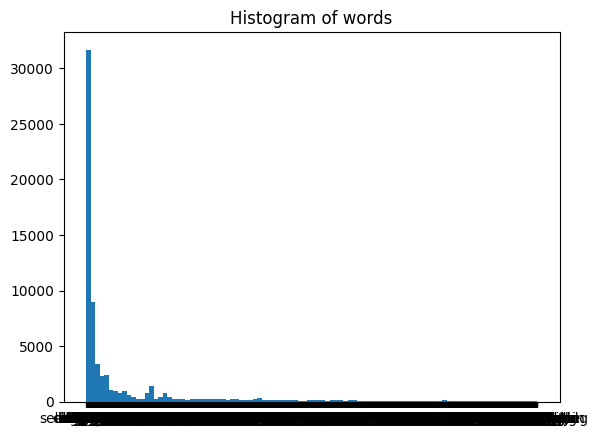

In [9]:
plt.hist(word_data.flatten(), bins = 100)
plt.title("Histogram of words")
plt.show()

In [10]:
def word_vocab(data):
    word_to_ix = {}
    for word in data.flatten():
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    return word_to_ix

word_to_ix = word_vocab(word_data)
ix_to_word = {v: k for k, v in word_to_ix.items()}
vocab_size = len(word_to_ix)
print("Vocabulary size: ", vocab_size)
print("Vocabulary: ", word_to_ix)

Vocabulary size:  3549
Vocabulary:  {'from': 0, 'fairest': 1, 'creatures': 2, 'we': 3, 'desire': 4, 'increase': 5, ',': 6, '0': 7, '~': 8, 'that': 9, 'thereby': 10, "beauty's": 11, 'rose': 12, 'might': 13, 'never': 14, 'die': 15, 'but': 16, 'as': 17, 'the': 18, 'riper': 19, 'should': 20, 'by': 21, 'time': 22, 'decease': 23, 'his': 24, 'tender': 25, 'heir': 26, 'bear': 27, 'memory': 28, ':': 29, '&': 30, 'thou': 31, 'contracted': 32, 'to': 33, 'thine': 34, 'own': 35, 'bright': 36, 'eyes': 37, "feed'st": 38, 'thy': 39, "light's": 40, 'flame': 41, 'with': 42, 'self-substantial': 43, 'fuel': 44, 'making': 45, 'a': 46, 'famine': 47, 'where': 48, 'abundance': 49, 'lies': 50, 'self': 51, 'foe': 52, '': 53, 'sweet': 54, 'art': 55, 'now': 56, "world's": 57, 'fresh': 58, 'ornament': 59, 'and': 60, 'only': 61, 'herald': 62, 'gaudy': 63, 'spring': 64, 'within': 65, 'bud': 66, 'buriest': 67, 'content': 68, 'churl': 69, "mak'st": 70, 'waste': 71, 'in': 72, 'niggarding': 73, 'pity': 74, 'world': 75, 

## Problem B

### Baseline LSTM

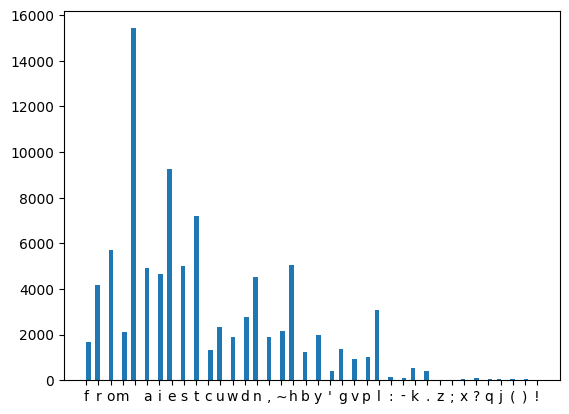

In [5]:
# Plotting the distribution of the characters
plt.hist(data, bins=100)
plt.show()

In [6]:
# Building Vocablury dictionary
temp = set(data)
vocab = {}
for i, character in enumerate(temp):
    vocab[character] = np.zeros(len(temp))
    vocab[character][i] = 1

In [7]:
baseline_train_data = []
baseline_train_labels = []

for i in range(len(data) - 1):
    baseline_train_data.append(vocab[data[i]])
    baseline_train_labels.append(vocab[data[i+1]])

baseline_train_data = np.array(baseline_train_data)
baseline_train_labels = np.array(baseline_train_labels)

baseline_train_data = torch.from_numpy(baseline_train_data)
baseline_train_labels = torch.from_numpy(baseline_train_labels)

seq_len = int(avg_sentence_len_char)
baseline_train_data = baseline_train_data[:len(baseline_train_data) - (len(baseline_train_data) % seq_len)]
baseline_train_labels = baseline_train_labels[:len(baseline_train_labels) - (len(baseline_train_labels) % seq_len)]

baseline_train_data = baseline_train_data.view(-1, seq_len, len(temp))
baseline_train_labels = baseline_train_labels.view(-1, seq_len, len(temp))

baseline_train_data = baseline_train_data.type(torch.FloatTensor)
baseline_train_labels = baseline_train_labels.type(torch.FloatTensor)

baseline_train_data = baseline_train_data.to(device)
baseline_train_labels = baseline_train_labels.to(device)

In [12]:
class baseline_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(baseline_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, (hidden, cell) = self.lstm(x, (h0, c0))
        out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        return out, hidden

In [13]:
baseline = baseline_LSTM(len(temp), 200, 1, len(temp))
baseline.to(device)

baseline_LSTM(
  (lstm): LSTM(38, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=38, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline.parameters(), lr=0.001)
# print(baseline_train_data[0].shape)

In [15]:
epochs = 1

for epoch in range(epochs):
    start = time.time()
    baseline.train()
    for i in range(0, len(baseline_train_data)):
        optimizer.zero_grad()
        input = baseline_train_data[i].view(1, seq_len, len(temp))
        input = input.to(device)
        output, hidden = baseline(input)
        output = output.to(device)
        labels = baseline_train_labels[i].view(1, seq_len, len(temp))
        labels = labels.to(device)
        loss = criterion(output.view(-1, len(temp)), labels.view(-1, len(temp)))
        loss.backward()
        optimizer.step()

    print('Epoch: {}/{}.............'.format(epoch+1, epochs), end=' ')
    print("Loss: {:.4f}".format(loss.item()))
    print("Time: {:.4f}".format(time.time() - start))

torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
torch.Size([1, 42, 38]) torch.Size([1, 1, 200]) torch.Size([1, 1

In [18]:
temp_raw = []
for i in range(len(raw_data)):
    if len(raw_data[i]) > 0:
        temp_raw.append(raw_data[i])

raw_data = temp_raw

In [19]:
# Batch implmentation
# batch_size = 512
# print(baseline_train_data.shape)
# batch_baseline_train_data = baseline_train_data.view(-1, batch_size, seq_len, len(temp))
# batch_baseline_train_labels = baseline_train_labels.view(-1, batch_size, seq_len, len(temp))

# batch_baseline_train_data = batch_baseline_train_data.to(device)
# batch_baseline_train_labels = batch_baseline_train_labels.to(device)

# epochs = 1

# for epoch in range(epochs):
#     baseline.train()
#     start = time.time()
#     for i in range(0, len(batch_baseline_train_data)):
#         optimizer.zero_grad()
#         input = batch_baseline_train_data[i]
#         input = input.to(device)
#         output, hidden = baseline(input)
#         output = output.to(device)
#         labels = batch_baseline_train_labels[i]
#         labels = labels.to(device)
#         loss = criterion(output.view(-1, len(temp)), labels.view(-1, len(temp)))
#         loss.backward()
#         optimizer.step()

#     print('Epoch: {}/{}.............'.format(epoch+1, epochs), end=' ')
#     print("Loss: {:.4f}".format(loss.item()))
#     print("Time: {:.4f}".format(time.time() - start))

In [20]:
def baseline_predict(model, input, seq_len, temperature, vocab):
    model.eval()
    input = input[-seq_len:]
    eval_input = []
    for i in range(len(input)):
        if input[i] in vocab:
            eval_input.append(vocab[input[i]])
        else:
            eval_input.append(vocab['~'])
    eval_input = np.array(eval_input)
    eval_input = torch.from_numpy(eval_input)
    eval_input = eval_input.view(1, seq_len, len(temp))
    eval_input = eval_input.type(torch.FloatTensor)
    eval_input = eval_input.to(device)
    output, hidden = model(eval_input)
    output = output.view(-1, len(temp))
    output = output[-1]
    output = output.cpu().detach().numpy()
    output = np.exp(output / temperature)
    output = output / np.sum(output)
    output = np.argmax(output)

    for key, value in vocab.items():
        for i in range(len(value)):
            if value[i] == 1:
                if i == output:
                    return key

In [21]:
# Generating all poems 1st lines
start_lines_char = []
for i in range(len(raw_data)):
    if (i) % 15 == 0:
        start_lines_char.append(raw_data[i+1])

In [22]:
poems = []
for i in range(len(start_lines_char)):
    temperature = 0.5
    test_start = start_lines_char[i]
    test_start = np.array([word for word in test_start])
    test_start = np.char.lower(test_start)
    while len(test_start) < seq_len:
        test_start = np.append(test_start, ' ')
    result = list(test_start)

    out_len = (seq_len * 14)

    size = out_len - len(test_start)

    for i in range(size):
        next_char = baseline_predict(baseline, result, seq_len, temperature, vocab)
        result.append(next_char)
    poems.append(result)

In [23]:
# Write the poems in list in a new file txt with ~ as line separator
poem_number = 1
with open('poems.txt', 'w') as f:
    for poem in poems:
        f.write('Poem number: ' + str(poem_number) + '\n')
        for i in range(len(poem)):
            if poem[i] == '~':
                f.write('\n')
            else:
                f.write(poem[i])
        f.write('\n')
        poem_number += 1
        f.write('\n')

In [24]:
temperatures = [1.5, 0.75, 0.25]
answer = []
for temperature in temperatures:
    test_start = "shall i compare thee to a summer’s day?"
    test_start = np.array([word for word in test_start])
    test_start = np.char.lower(test_start)
    while len(test_start) < seq_len:
        test_start = np.append(test_start, ' ')
    result = list(test_start)

    out_len = int(avg_sentence_len_char * 14)

    size = out_len - len(test_start)

    for i in range(size):
        next_char= baseline_predict(baseline, result, seq_len, temperature, vocab)
        result.append(next_char)
    answer.append(result)

/tmp/ipykernel_277290/1090504549.py:19: RuntimeWarning: overflow encountered in exp
  output = np.exp(output / temperature)
/tmp/ipykernel_277290/1090504549.py:20: RuntimeWarning: invalid value encountered in divide
  output = output / np.sum(output)


In [25]:
for i in range(len(answer)):
    print('Temperature: ' + str(temperatures[i]))
    for j in range(len(answer[i])):
        if answer[i][j] == '~':
            print('\n')
        else:
            print(answer[i][j], end='')
    print('\n')

Temperature: 1.5
shall i compare thee to a summer’s day?   weet to thee.

my fraist for where i harw, who shall nimb the dead rone,

so shall be other nature's time me will my deed

a look, to sell night which thou my love thou are showers.

and to see thy fair forth not speak of thy ame

for who all men one one of thy hunour dear,

against thief i do but proved the stile,

a weathers to calls on me to good are dears

which makel by thy dear heart to mourned of thy worth,

and all thou tirt a fememy rans, or truth and beauty live, agains have sweet.

then in thy soucious hand dwell.

that you wilt thou art my

Temperature: 0.75
shall i compare thee to a summer’s day?   weet to thee.

my fraist for where i harw, who shall nimb the dead rone,

so shall be other nature's time me will my deed

a look, to sell night which thou my love thou are showers.

and to see thy fair forth not speak of thy ame

for who all men one one of thy hunour dear,

against thief i do but proved the stile,

a we

In [26]:
# Ground truth

# Shall I compare thee to a summer's day?
# Thou art more lovely and more temperate:
# Rough winds do shake the darling buds of May,
# And summer's lease hath all too short a date:
# Sometime too hot the eye of heaven shines,
# And often is his gold complexion dimmed,
# And every fair from fair sometime declines,
# By chance, or nature's changing course untrimmed:
# But thy eternal summer shall not fade,
# Nor lose possession of that fair thou ow'st,
# Nor shall death brag thou wand'rest in his shade,
# When in eternal lines to time thou grow'st,
#   So long as men can breathe or eyes can see,
#   So long lives this, and this gives life to thee.


## Problem C

In [27]:
def word_one_hot(word, vocab):
    if word not in vocab:
        word = '~'
    data = np.zeros(len(vocab))
    data[vocab[word]] = 1
    return data

In [28]:
word_train_data = []
word_train_labels = []

for i in range(len(word_data) - 1):
    for j in range(len(word_data[i])):
        word_train_data.append(word_one_hot(word_data[i][j], word_to_ix))
        word_train_labels.append(word_one_hot(word_labels[i][j], word_to_ix))

word_train_data = np.array(word_train_data)
word_train_labels = np.array(word_train_labels)

In [29]:
sequence_len = sequence * (max_sentence_len_word + 1)

word_train_data = torch.from_numpy(word_train_data)
word_train_labels = torch.from_numpy(word_train_labels)

word_train_data = word_train_data[:len(word_train_data) - (len(word_train_data) % sequence_len)]
word_train_labels = word_train_labels[:len(word_train_labels) - (len(word_train_labels) % sequence_len)]

word_train_data = word_train_data.reshape(-1, sequence_len, len(word_to_ix))
word_train_labels = word_train_labels.reshape(-1, sequence_len, len(word_to_ix))


word_train_data = word_train_data.type(torch.FloatTensor)
word_train_labels = word_train_labels.type(torch.FloatTensor)

word_train_data = word_train_data.to(device)
word_train_labels = word_train_labels.to(device)

In [30]:
class mod_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(mod_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)

        out, (hidden, cell) = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

In [31]:
model = mod_LSTM(len(word_to_ix), 400, len(word_to_ix), 3)
model.to(device)

mod_LSTM(
  (lstm): LSTM(3549, 400, num_layers=3, batch_first=True)
  (fc): Linear(in_features=400, out_features=3549, bias=True)
)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer_mod = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
epochs = 100
print(word_train_data.shape)
print(baseline_train_data.shape)

for epoch in range(epochs):
    start = time.time()
    model.train()
    for i in range(len(word_train_data)):
        optimizer_mod.zero_grad()
        input = word_train_data[i].view(1, sequence_len, len(word_to_ix))
        label = word_train_labels[i].view(1, sequence_len, len(word_to_ix))
        input = input.to(device)
        label = label.to(device)
        output = model(input)
        output = output.to(device)
        loss = criterion(output.view(-1, len(word_to_ix)), label.view(-1, len(word_to_ix)))
        loss.backward()
        optimizer_mod.step()
    end = time.time()
    print("Epoch: {}/{}...".format(epoch+1, epochs),
            "Loss: {:.6f}...".format(loss.item()),
            "{:.4f} sec/batch".format((end-start)))
    


torch.Size([2152, 32, 3549])
torch.Size([2230, 42, 38])
Epoch: 1/100... Loss: 4.917017... 257.8547 sec/batch
Epoch: 2/100... Loss: 4.453625... 320.8156 sec/batch
Epoch: 3/100... Loss: 4.151184... 318.2939 sec/batch
Epoch: 4/100... Loss: 3.927141... 306.4603 sec/batch
Epoch: 5/100... Loss: 3.796978... 327.3859 sec/batch


KeyboardInterrupt: 

In [ ]:
def model_predict(model, data, seq_len, temperature, vocab):
    model.eval()
    input = data[-seq_len:]
    input = torch.from_numpy(input)
    input = input.view(1, seq_len, len(vocab))
    input = input.type(torch.FloatTensor)
    input = input.to(device)
    output = model(input)
    output = output.view(-1, len(vocab))
    output = output[-1]
    output = output.cpu().detach().numpy()
    output = np.exp(output) / temperature
    output = output / np.sum(output)
    output = np.argmax(output)

    for word, index in vocab.items():
        if index == output:
            return word

In [ ]:
start_seq = []
for i in range(len(raw_data)):
    if i % 15 == 0:
        temp = []
        for j in range(sequence):
            temp.append(raw_data[i+j+1])
        start_seq.append(temp)   

In [ ]:
print(start_seq[0])

['From fairest creatures we desire increase,', "That thereby beauty's rose might never die,"]


In [ ]:
answer_c = []
for i in range(len(start_seq)):

    test = []

    for j in range(len(start_seq[i])):

        test.append(start_seq[i][j].split())

    temperature = 0.5
    word_list = []
    for sentence in test:
        words = sentence
        line = []
        for i in range(len(words)):
            if split_hyphen:
                temp = words[i].split('-')
                for j in range(len(temp)):
                    line.append(temp[j])
                    if j < len(temp) - 1:
                        line.append('-')
            else:
                line.append(words[i])
            if i < len(words) - 1 and space:
                line.append(' ')  

        word_list.append(line)

    for i in range(len(word_list)):
        for j in range(len(word_list[i])):
            if word_list[i][j][-1] in string.punctuation:
                punctuations = word_list[i][j][-1]
                word_list[i][j] = word_list[i][j][:-1]
                word_list[i].insert(j+1, punctuations)
        if (i+1) % 2 == 0:
            word_list[i].append('&')
        else:
            word_list[i].append('~')


    data = []
    for i in range(len(word_list)):
        temp = []
        for j in range(max_sentence_len_word+1):
            if j < len(word_list[i]):
                temp.append(word_list[i][j])
            else:
                temp.append('0')
        data.append(temp)
    
    word_list = []

    for i in range(0, len(data)):
        temp = []
        if i + sequence > len(data):
            break
        for j in range(sequence):
            temp.append(data[i+j])
        word_list.append(temp)

    data = []
    for i in range(len(word_list)):
        temp = []
        for j in range(sequence):
            temp = temp + word_list[i][j]
        data.append(temp)
    
    data = np.array(data)
    data = np.char.lower(data)
    
    test = data

    test = np.reshape(test, test.shape[1])
    result = list(test)
    test_data = []
    for i in range(test.shape[0]):
        test_data.append(word_one_hot(test[i], word_to_ix))

    test_data = np.array(test_data)
    out_len = (max_sentence_len_word + 1) * 14
    size = out_len - test_data.shape[0]

    for i in range(size):
        next_word = model_predict(model, test_data, sequence_len, temperature, word_to_ix)
        result.append(next_word)
    answer_c.append(result)

In [ ]:
poem_number = 1
with open('poems_c.txt', 'w') as f:
    for poem in answer_c:
        f.write('Poem number: ' + str(poem_number) + '\n')
        for i in range(len(poem)):
            if poem[i] == '0':
                continue
            if poem[i] == '~' or poem[i] == '|' or poem[i] == '&':
                f.write('\n')
            else:
                f.write(poem[i] + ' ')
        f.write('\n')
        poem_number += 1
        f.write('\n')